In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import prophet as Prophet
from scipy import stats
import math

Importing plotly failed. Interactive plots will not work.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AML_exam.txt to AML_exam.txt


In [2]:
df = pd.read_csv('AML_exam.txt',sep='\t',header=(0))

In [3]:
df.drop('Unnamed: 0',inplace=True,axis=1)

In [4]:
df['datetime']=pd.to_datetime(df['datetime'],format='%Y%m%d%H%M%S')

In [5]:
df.set_index('datetime')

,speed
datetime,
2015-01-01 00:00:00,NaN
2015-01-01 01:00:00,NaN
2015-01-01 02:00:00,NaN
2015-01-01 03:00:00,NaN
2015-01-01 04:00:00,NaN
...,...
2018-12-31 19:00:00,2.148734
2018-12-31 20:00:00,1.608662
2018-12-31 21:00:00,0.647012


Data cleaning and removing of null values. 

In [6]:
df.isnull().sum()

datetime        0
speed       16515
dtype: int64

In [7]:
df.loc[(df.datetime <= '2015-01-01 00:00:00') | (df.datetime >= '2015-01-31 00:00:00')]

,datetime,speed
0,2015-01-01 00:00:00,NaN
720,2015-01-31 00:00:00,NaN
721,2015-01-31 01:00:00,NaN
722,2015-01-31 02:00:00,NaN
723,2015-01-31 03:00:00,NaN
...,...,...
35059,2018-12-31 19:00:00,2.148734
35060,2018-12-31 20:00:00,1.608662
35061,2018-12-31 21:00:00,0.647012
35062,2018-12-31 22:00:00,1.206987


In [8]:
df_2015 = df[(df['datetime'] > '2014-12-31') & (df['datetime'] < '2016-01-01')]

In [9]:
len(df_2015)

8760

In [10]:
df_2015.speed.isnull().sum()

8760

In [11]:
#Drop years values in this range for the year 2015
df=df[~df.datetime.isin(df_2015.datetime)]

In [12]:
df_2016 = df[(df['datetime'] > '2015-12-31') & (df['datetime'] < '2017-01-01')&(df.speed.isnull()==True)]

In [13]:
#Drop years values in this range for the year 2015
df=df[~df.datetime.isin(df_2016.datetime)]

In [14]:
df.isnull().sum()

datetime     0
speed       15
dtype: int64

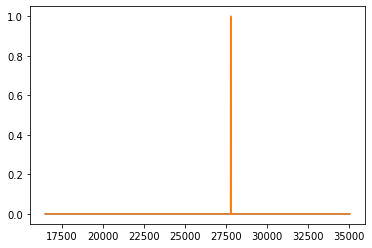

In [15]:
plt.plot(df.isnull())

In [16]:
#Fill the rest of the null values with the mean
df.fillna(df.speed.mean(),inplace=True)

In [17]:
#Check for more null values
df.isnull().sum()

datetime    0
speed       0
dtype: int64

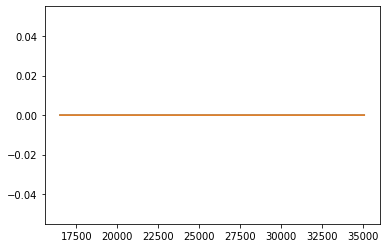

In [18]:
#All null values have been dealt with.
plt.plot(df.isnull())

In [19]:
data = df['speed'].values

In [114]:
df2 = df.set_index('datetime')

In [122]:
df['ds'] = df['datetime']
df['y'] = df['speed']

In [49]:
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

In [20]:
train_size = int(len(data)*0.7)
test_size = int(len(data)*0.3)

X_train = data[0:train_size]
X_test = data[train_size:len(data)]

To split the univariate feature into X and Y. I used a function that takes in the data, given the window it will produce a vector with and X vector and Y scalar. 

In [21]:
#Feature extraction
def sequences(data, combination=1):
    x = []
    y = []

    for i in range(len(data)-combination-1):
        window = data[i:(i+combination)]
        x.append(window)
        y.append(data[i+combination])
        
    return np.array(x),np.array(y)

combination= 24  # Number of time steps to look back 

X_train, Y_train = sequences(X_train, combination)
X_test, Y_test = sequences(X_test, combination)
#X, Y = sequences(filter_d, combination)

The parameters that the kernel that was used in this part of the training is laplacian. It tended to have produced better results that polynomial, rbf or linear. The data was split using TimeSeriesSplit. 

In [27]:
# Parameters for grid search cv
param_grid = {"alpha":[100, 10, 1e0, 1e-1, 1e-2, 1e-3,1e-4],
              "kernel":['laplacian'],
              "gamma":[100, 10, 1e0, 1e-1, 1e-2, 1e-3,1e-4], #[10,1e0, 1e-1, 1e-2, 1e-3,1e-4],
              "degree":[3,4]
              }

tscv = TimeSeriesSplit(n_splits=3)
kr = GridSearchCV(KernelRidge(), param_grid=param_grid, cv=tscv,return_train_score=True)

Different data splits and there respective Scores and RMSEs.

In [54]:
score = []
datasize = []
alphas = []
gammas = []
X_tr_s = []
X_te_s = []
Y_pre_tr = []
Y_pre_te = []

raw_data = []

X_train_data = []
Y_train_data = []
X_test_data = []
Y_test_data = []


for i in np.linspace(0.05,0.3,10):
  data = df['speed'].values
  dat = data[:int(data.shape[0]*i)]
    
  raw_data.append(dat)  
  print("Data percentage :",i,"Data points :",dat.shape)
  print (pd.DataFrame(dat).describe())
  
  a_cor = autocorr(dat, t=1)
  print("Data AutoCorrelation :",a_cor)  

  train_size = int(len(dat)*0.7)
  test_size = int(len(dat)*0.3)
  
  X_train = dat[0:train_size]
  X_test = dat[train_size:len(dat)]

  X_train, Y_train = sequences(X_train, combination)
  X_test, Y_test = sequences(X_test, combination)
    
  X_train_data.append(X_train)
  X_test_data.append(X_test)
  Y_train_data.append(Y_train)
  Y_test_data.append(Y_test)  

  train = kr.fit(X_train,Y_train)
  al = train.best_score_
  score.append(al)
  datasize.append(i)
  alphas.append(train.best_params_['alpha'])
  gammas.append(train.best_params_['gamma'])

  X_ = train.score(X_train,Y_train)
  X_tr_s.append(X_)
  Xte_= train.score(X_test,Y_test)
  X_te_s.append(Xte_)

  Y_pred_train = train.predict(X_train)

  #Y_pre_tr = []
  #Y_pre_te = []
  Y_pred_test = train.predict(X_test)



  trainScore = math.sqrt(mean_squared_error(Y_train,Y_pred_train ))
  Y_pre_tr.append(trainScore)

  testScore = math.sqrt(mean_squared_error(Y_test, Y_pred_test))
  Y_pre_te.append(testScore)
    
  
  print("Train RMSE :",trainScore, "Test RMSE :",testScore)
  print("Score :",al)
  print("Train Score :",X_)
  print("Test Score :",Xte_)  
  print() 
  
  import warnings
  warnings.simplefilter('ignore')

Data percentage : 0.05 Data points : (928,)
                0
count  928.000000
mean     1.350976
std      0.601742
min      0.000000
25%      0.939612
50%      1.372027
75%      1.792317
max      3.213816
Data AutoCorrelation : [[1.         0.66176651]
 [0.66176651 1.        ]]
Train RMSE : 0.30395235967605305 Test RMSE : 0.4089264169234832
Score : 0.4043027056570092
Train Score : 0.7501069525446982
Test Score : 0.5232690401166066

Data percentage : 0.07777777777777778 Data points : (1443,)
                 0
count  1443.000000
mean      1.584975
std       0.813476
min       0.000000
25%       1.045764
50%       1.569661
75%       2.003954
max       5.397056
Data AutoCorrelation : [[1.         0.76260948]
 [0.76260948 1.        ]]
Train RMSE : 0.31880822218449556 Test RMSE : 0.692964441546932
Score : 0.3929394205950698
Train Score : 0.7626795142671475
Test Score : 0.5171264151220999

Data percentage : 0.10555555555555556 Data points : (1959,)
                 0
count  1959.000000
mean

In [104]:
df_thirtyr = df.iloc[0:5569, ]

In [106]:
df_thirtyr = df_thirtyr.set_index('datetime')

Results from the different data splits for the training of the KRR. The first section will deal with hyperparameters tuning.

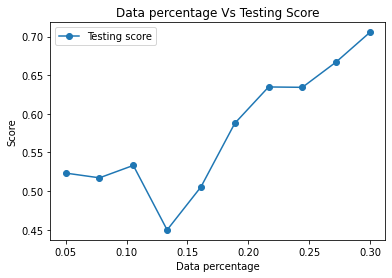

In [30]:
plt.plot(datasize, X_te_s,'o-',label='Testing score')
plt.title("Data percentage Vs Testing Score")
plt.xlabel("Data percentage")
plt.ylabel("Score")
plt.legend()

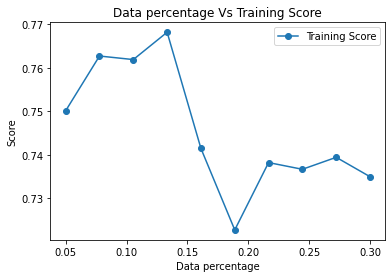

In [31]:
plt.plot(datasize, X_tr_s,'o-',label="Training Score")
plt.title("Data percentage Vs Training Score")
plt.xlabel("Data percentage")
plt.ylabel("Score")
plt.legend()

Text(0, 0.5, 'Gammas')

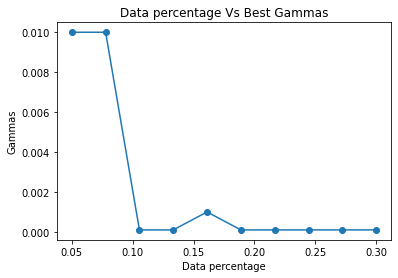

In [32]:
plt.plot(datasize, gammas,'o-',label="gammas")
plt.title("Data percentage Vs Best Gammas")
plt.xlabel("Data percentage")
plt.ylabel("Gammas")

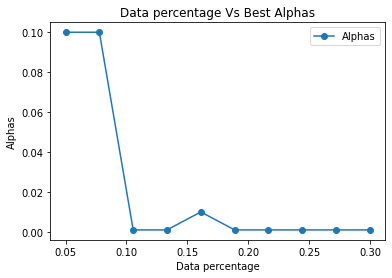

In [33]:
plt.plot(datasize, alphas,'o-',label='Alphas')
plt.title("Data percentage Vs Best Alphas")
plt.xlabel("Data percentage")
plt.ylabel("Alphas")
plt.legend()

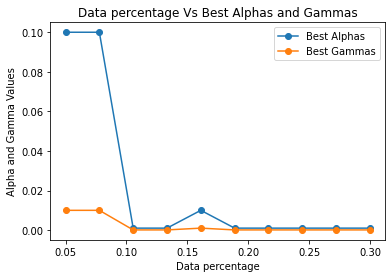

In [34]:
plt.plot(datasize, alphas,'o-',label='Best Alphas')
plt.plot(datasize, gammas,'o-',label='Best Gammas')
plt.title("Data percentage Vs Best Alphas and Gammas")
plt.xlabel("Data percentage")
plt.ylabel("Alpha and Gamma Values")
plt.legend()

Text(0, 0.5, 'RMSE')

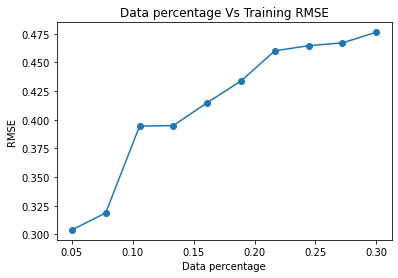

In [35]:
plt.plot(datasize,Y_pre_tr,'o-')
plt.title("Data percentage Vs Training RMSE")
plt.xlabel("Data percentage")
plt.ylabel("RMSE")

Text(0, 0.5, 'RMSE')

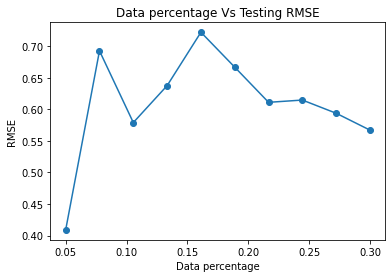

In [36]:
plt.plot(datasize,Y_pre_te ,'o-')
plt.title("Data percentage Vs Testing RMSE")
plt.xlabel("Data percentage")
plt.ylabel("RMSE")

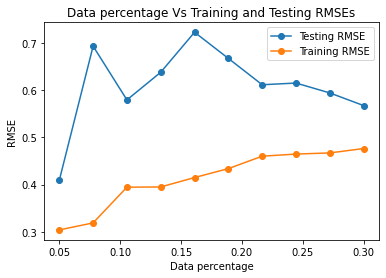

In [37]:
plt.plot(datasize,Y_pre_te ,'o-',label='Testing RMSE')
plt.plot(datasize,Y_pre_tr,'o-',label='Training RMSE')
plt.title("Data percentage Vs Training and Testing RMSEs")
plt.xlabel("Data percentage")
plt.ylabel("RMSE")
plt.legend()

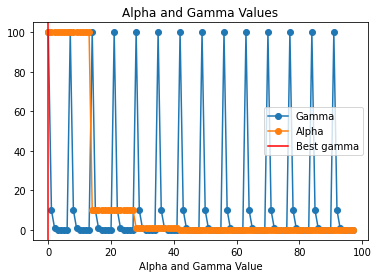

In [38]:
plt.plot(train.cv_results_['param_gamma'].data,'o-',label='Gamma')
plt.plot(train.cv_results_['param_alpha'].data,'o-', label='Alpha')
plt.axvline(train.best_params_['gamma'], color='red',label='Best gamma')
#plt.axvline(train.best_params_['alpha'], color='green')
plt.title("Alpha and Gamma Values")
plt.xlabel("Alpha and Gamma Value")
plt.legend()

Do some statistical analysis on the dataset that is 30% of the original. 

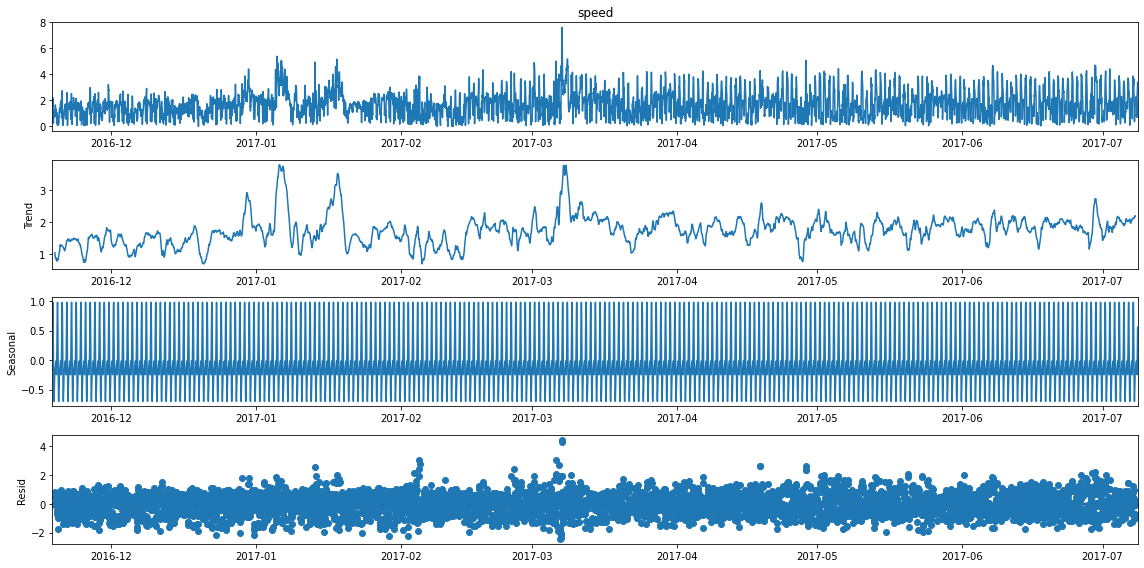

In [112]:
results = seasonal_decompose(df_thirtyr['speed'])
plt.rc("figure", figsize=(16,8))
results.plot();

Predicted values for the 30% data split section. 

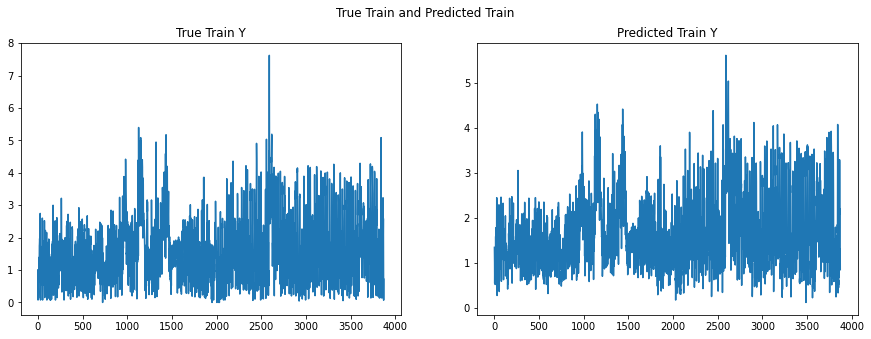

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('True Train and Predicted Train')
ax1.plot(Y_train_data[-1])
ax1.set_title('True Train Y')
ax2.plot(train.predict(X_train_data[-1]))
ax2.set_title('Predicted Train Y')
fig.set_figheight(5)
fig.set_figwidth(15)

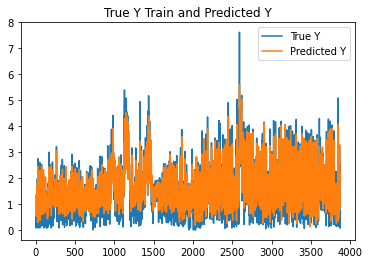

In [56]:
plt.plot(Y_train_data[-1], label= "True Y")
plt.plot(train.predict(X_train_data[-1]), label= "Predicted Y")
plt.title('True Y Train and Predicted Y')
plt.legend()

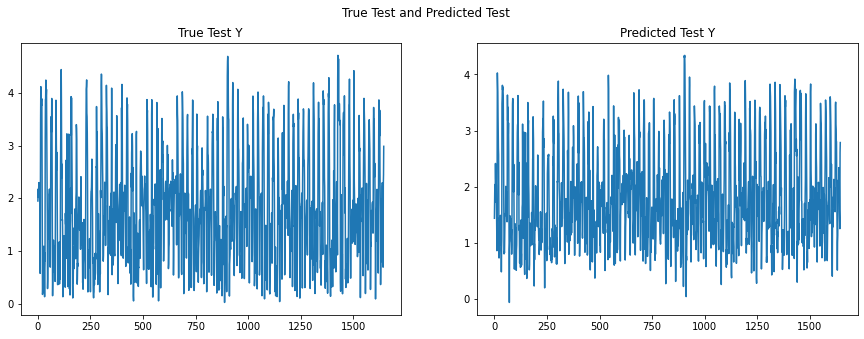

In [59]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('True Test and Predicted Test')
ax1.plot(Y_test_data[-1])
ax1.set_title('True Test Y')
ax2.plot(train.predict(X_test_data[-1]))
ax2.set_title('Predicted Test Y')
fig.set_figheight(5)
fig.set_figwidth(15)

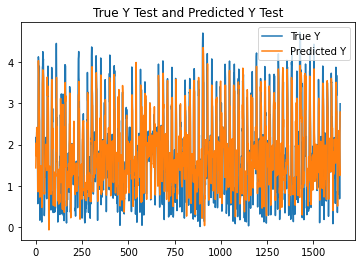

In [60]:
plt.plot(Y_test_data[-1], label= "True Y")
plt.plot(train.predict(X_test_data[-1]), label= "Predicted Y")
plt.title('True Y Test and Predicted Y Test')
plt.legend()

Predict the next 1 and 3rd hours of wind speed for the last data point which is 30% of the original dataset.

In [80]:
#We are going to use the previous 24hours in the sequence to predict the next. 
prev_24hrs = X_test_data[-1][0:3]
Y_test_data[-1][0:3]

array([1.9484222 , 2.17425271, 2.02161288])

In [81]:
#Predicted next 4hrs
train.predict(prev_24hrs)

array([1.43838029, 1.84569996, 2.03898543])

Forecast the whole dataset with prophet. Since its not resource intensive.

In [128]:
df_p2 = df[['ds','y']]
m = Prophet.Prophet()
m.fit(df_p2)
future = m.make_future_dataframe(periods=365, freq='H')
forecast = m.predict(future)

In [129]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
18924,2019-01-16 00:00:00,1.356374,0.278631,2.343855
18925,2019-01-16 01:00:00,1.389267,0.306377,2.441598
18926,2019-01-16 02:00:00,1.403093,0.423745,2.453173
18927,2019-01-16 03:00:00,1.432332,0.381180,2.465131
18928,2019-01-16 04:00:00,1.484060,0.480388,2.537620


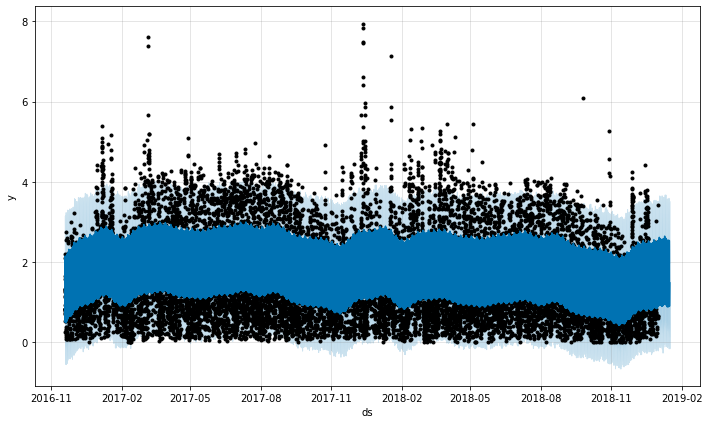

In [130]:
figfore = m.plot(forecast)

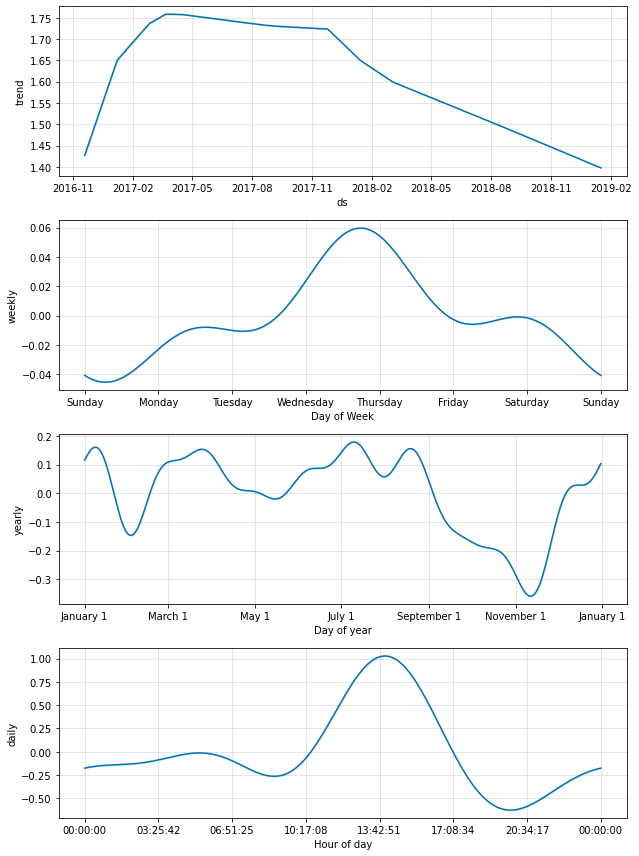

In [131]:
figseasonaliy = m.plot_components(forecast)